In [70]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, multinomial
from scipy.special import softmax

np.random.seed(42)

# Settings
num_companies = 40
num_categories = 3  # categories: 0 (pivot), 1, 2 minimal non-trivial 


# 1. Generate random effects for each company (for categories 1-3, pivot is category 0)
mean_effect = np.zeros(num_categories - 1)
# Define covariance matrix with correlations between categories
cov_effect = np.array([
    [1.0, 0.5],
    [0.5, 2.0]
])

company_effects = multivariate_normal.rvs(mean=mean_effect, cov=cov_effect, size=num_companies)
# Add pivot logits = 0
company_effects = np.hstack([np.zeros((num_companies, 1)), company_effects])

# Store company random effects in a DataFrame
company_ids = [f'company_{i}' for i in range(num_companies)]
company_effects_df = pd.DataFrame(company_effects, columns=[f'logit_{i}' for i in range(num_categories)])
company_effects_df['company'] = company_ids

# 2. Generate observations per company
data = []
for idx, company in enumerate(company_ids):
    n_obs = np.random.randint(7, 11)  # Between 1 and 10 observations per company
    
  
    logits = company_effects[idx]
    probs = softmax(logits)
    for obs in range(n_obs):
          
        observed_type = np.random.choice(num_categories, p=probs)
        
        # Append observation
        data.append({
            'company': company,
            'company_id' : idx,
            'type': f'type_{observed_type}',
            'type_id': observed_type,
        })

# Convert to DataFrame
simulated_df = pd.DataFrame(data)


print(simulated_df.head(10))


     company  company_id    type  type_id
0  company_0           0  type_0        0
1  company_0           0  type_2        2
2  company_0           0  type_2        2
3  company_0           0  type_0        0
4  company_0           0  type_2        2
5  company_0           0  type_2        2
6  company_0           0  type_2        2
7  company_0           0  type_2        2
8  company_1           1  type_2        2
9  company_1           1  type_1        1


Work in progress... still not doing what i think it should be doing. I want it to do what (1 | type | company) does in brms

In [35]:
import bambi as bmb

model = bmb.Model('type ~  0+ (1| company)', data=simulated_df, family='categorical')
results = model.fit()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|company_sigma, 1|company_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [36]:
import arviz as az
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|company_sigma,0.873,0.160,0.585,1.185,0.004,0.003,1389.0,2249.0,1.0
"1|company[type_1, company_0]",-0.804,0.723,-2.202,0.477,0.012,0.012,3974.0,2464.0,1.0
"1|company[type_1, company_1]",0.634,0.640,-0.549,1.854,0.011,0.010,3529.0,3155.0,1.0
"1|company[type_1, company_10]",-0.167,0.713,-1.489,1.190,0.011,0.011,3957.0,2898.0,1.0
"1|company[type_1, company_11]",-0.923,0.706,-2.246,0.422,0.012,0.012,3325.0,2671.0,1.0
...,...,...,...,...,...,...,...,...,...
"1|company[type_2, company_5]",-0.304,0.603,-1.504,0.745,0.009,0.010,4337.0,2993.0,1.0
"1|company[type_2, company_6]",1.088,0.574,0.053,2.193,0.009,0.009,4074.0,2551.0,1.0
"1|company[type_2, company_7]",-1.106,0.713,-2.443,0.203,0.012,0.013,3807.0,2773.0,1.0
"1|company[type_2, company_8]",-0.654,0.626,-1.843,0.489,0.010,0.011,4100.0,2720.0,1.0


In [64]:
import pymc as pm
import pytensor.tensor as pt

num_companies = simulated_df["company_id"].nunique()
num_categories = 3  # total categories, including baseline
num_obs = simulated_df.shape[0]

with pm.Model() as model:
    # Data explicitly
    company_idx = pm.MutableData("company_idx", simulated_df["company_id"].values)
    type_obs = pm.MutableData("type_obs", simulated_df["type_id"].values)
    sd_dist = pm.StudentT.dist(nu=3, mu=0, sigma=2.5)
    # Explicitly unpack LKJCholeskyCov output (Cholesky factor only)
    chol_corr,_, _ = pm.LKJCholeskyCov(
        "chol_corr",
        n=num_categories - 1,
        eta=1,
         sd_dist=sd_dist
    )

    # Random intercepts explicitly
    z_company = pm.Normal(
        "z_company",
        0, 1,
        shape=(num_companies, num_categories - 1)
    )

    # Correlated random effects explicitly (no ambiguity now)
    company_effects_m = pm.Deterministic(
        "company_effects",
        pt.dot(z_company, chol_corr.T),  # now works explicitly
    )

    # Proper indexing explicitly
    company_eff_obs = company_effects_m[company_idx, :]  # (num_obs, num_categories - 1)

    # Explicit logits
    logits = pt.concatenate(
        [pt.zeros((num_obs, 1)), company_eff_obs],
        axis=1
    )

    # Categorical likelihood explicitly
    pm.Categorical("obs", logit_p=logits, observed=type_obs)

    # Sampling explicitly
    trace = pm.sample(draws=1000, tune=1000, chains=4, cores=4, target_accept=0.9)


/Users/ronaldlegere/miniconda3/envs/multinom/lib/python3.13/site-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_corr, z_company]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [65]:
az.summary(trace, var_names = ["~z_company","~company_effects"])

/Users/ronaldlegere/miniconda3/envs/multinom/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/ronaldlegere/miniconda3/envs/multinom/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
chol_corr[0],0.958,0.272,0.461,1.486,0.009,0.006,993.0,1255.0,1.0
chol_corr[1],0.181,0.310,-0.397,0.759,0.010,0.005,1047.0,1865.0,1.0
chol_corr[2],0.802,0.247,0.294,1.251,0.008,0.006,1086.0,733.0,1.0
"chol_corr_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,NaN,4000.0,4000.0,NaN
"chol_corr_corr[0, 1]",0.171,0.333,-0.469,0.728,0.010,0.007,1116.0,1390.0,1.0
"chol_corr_corr[1, 0]",0.171,0.333,-0.469,0.728,0.010,0.007,1116.0,1390.0,1.0
"chol_corr_corr[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,4069.0,3624.0,1.0
chol_corr_stds[0],0.958,0.272,0.461,1.486,0.009,0.006,993.0,1255.0,1.0
chol_corr_stds[1],0.873,0.268,0.342,1.374,0.008,0.006,1062.0,853.0,1.0


In [66]:
posterior = trace.posterior

# means over chains and draws
mean_stds = posterior['chol_corr_stds'].mean(dim=['chain', 'draw']).values
mean_corr = posterior['chol_corr_corr'].mean(dim=['chain', 'draw']).values

# explicitly reconstruct covariance matrix: Cov = D * Corr * D
cov_matrix_reconstructed = np.outer(mean_stds, mean_stds) * mean_corr

print("Posterior mean covariance matrix:")
print(cov_matrix_reconstructed)

Posterior mean covariance matrix:
[[0.9183107  0.14302259]
 [0.14302259 0.76159243]]


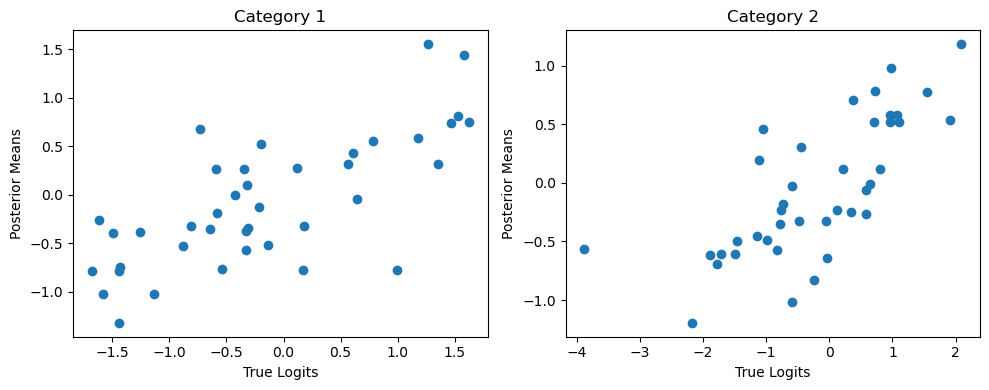

In [71]:
# true logits you generated from
true_effects = company_effects[:, 1:]  # exclude baseline logits

# posterior means explicitly
posterior_means = trace.posterior["company_effects"].mean(dim=["chain", "draw"]).values

# explicitly plot or correlate posterior vs true
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for i in range(2):
    axes[i].scatter(true_effects[:, i], posterior_means[:, i])
    axes[i].set_xlabel("True Logits")
    axes[i].set_ylabel("Posterior Means")
    axes[i].set_title(f"Category {i+1}")

plt.tight_layout()
plt.show()


In [59]:
posterior = trace.posterior

# means over chains and draws
mean_stds = posterior['chol_corr_stds'].mean(dim=['chain', 'draw']).values
mean_corr = posterior['chol_corr_corr'].mean(dim=['chain', 'draw']).values

# explicitly reconstruct covariance matrix: Cov = D * Corr * D
cov_matrix_reconstructed = np.outer(mean_stds, mean_stds) * mean_corr

print("Posterior mean covariance matrix:")
print(cov_matrix_reconstructed)

Posterior mean covariance matrix:
[[0.88329214 0.11421592]
 [0.11421592 0.74736829]]
